In [101]:
%config Completer.use_jedi = False

import sys
sys.path.insert(1,'../')



# Pytorch related
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data as dt
from torchinfo import summary
import torchvision.models as pretrained_models
from alexnet_pytorch import AlexNet
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo



# Numpy, Matplotlib, Pandas, Sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from sklearn import manifold
from sklearn.decomposition import PCA
from scipy.spatial import distance
from scipy.stats.stats import pearsonr 
%matplotlib inline



# python utilities
from itertools import combinations
import pickle
from tqdm import tqdm_notebook as tqdm
import copy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
from IPython.display import Image
from IPython.core.debugger import set_trace
import collections
from functools import partial
import math
import time

from PIL import Image, ImageStat
from matplotlib.pyplot import imshow

# Extra imports
# from pytorch_pretrained_vit import ViT
# from models import barlow_twins
from lib.feature_extractor import FeatureExtractor
# from lib.custom_dataset import Contour_Dataset
# from lib.build_fe_ft_models import *
from lib.utility_functions import imshow_grid
from field_stim_functions import *
from lib.receptive_fields import *


In [102]:
import math
from PIL import Image, ImageDraw
import numpy as np
from IPython.html.widgets import interact, interactive, fixed
from IPython.display import display 

# Hyperparameters

In [103]:
device='cpu'
device = torch.device('cuda:0')

In [104]:
current_layer='features.4'


# Helper functions -I

In [105]:
#finds the straight-line distance between two points
def distance(ax, ay, bx, by):
    return math.sqrt((by - ay)**2 + (bx - ax)**2)

#rotates point `A` about point `B` by `angle` radians clockwise.
def rotated_about(ax, ay, bx, by, angle):
    radius = distance(ax,ay,bx,by)
    angle += math.atan2(ay-by, ax-bx)
    return (
        round(bx + radius * math.cos(angle)),
        round(by + radius * math.sin(angle))
    )

In [315]:
def imscale(im, minVal=None, maxVal=None):
    # first resclae the image between 0 and 1 -> It is important to set the bounds as -1 and 1 because the data itself will be restricted between -1 and 1
    minVal = im.min() if minVal is None else minVal
    maxVal = im.max() if maxVal is None else maxVal
    tempIm = (im - minVal)/(maxVal-minVal);
    
    return tempIm

def get_image(imHeight=512, imWidth=512):
    '''
    
    '''
    img = np.zeros((imHeight,imWidth,3))
    
    img = imscale(img, -1, 1)
    img = np.array(img*255).astype(np.uint8)
   
    
    return Image.fromarray(img.astype(np.uint8))

def embed_norm(img, background, startX, startY):
    
    H,W = background.shape
    maxH,maxW = H, W
    h,w = img.shape
    endX = startX + w
    endY = startY + h
    
    bg_startX = max(0,startX)
    bg_startY = max(0,startY)
    bg_endX = min(endX, maxW)
    bg_endY = min(endY, maxH)

    im_startX = 0 if startX > 0 else abs(startX)
    im_startY = 0 if startY > 0 else abs(startY)
    im_endX = w if endX < maxW else w-(endX-maxW)
    im_endY = h if endY < maxH else h-(endY-maxH)
    
    background[bg_startY:bg_endY,bg_startX:bg_endX] += img[im_startY:im_endY,im_startX:im_endX]
    
    ## Normalize between -1 and 1 and then between 0 and 255
    background = np.clip(background, -1,1)
    background = Image.fromarray((background*127.5+127.5).astype(np.uint8))
    
    
    return background 

In [321]:
def just_norm(background):
    
    ## Normalize between -1 and 1 and then between 0 and 255
    background = np.clip(background, -1,1)
    background = Image.fromarray((background*127.5+127.5).astype(np.uint8))
    
    
    return background 



def embed_norm_mask(img, background, startX, startY,mask):
    
    H,W = background.shape
    maxH,maxW = H, W
    h,w = img.shape
    endX = startX + w
    endY = startY + h
    
    bg_startX = max(0,startX)
    bg_startY = max(0,startY)
    bg_endX = min(endX, maxW)
    bg_endY = min(endY, maxH)

    im_startX = 0 if startX > 0 else abs(startX)
    im_startY = 0 if startY > 0 else abs(startY)
    im_endX = w if endX < maxW else w-(endX-maxW)
    im_endY = h if endY < maxH else h-(endY-maxH)
    
    background[bg_startY:bg_endY,bg_startX:bg_endX] += img[im_startY:im_endY,im_startX:im_endX]
    background=background*mask
    
    ## Normalize between -1 and 1 and then between 0 and 255
    background = np.clip(background, -1,1)
    background = Image.fromarray((background*127.5+127.5).astype(np.uint8))
    
    
    return background 

# PART A: Exploring the stimuli

### Interactive - get both constrast versions

In [107]:
@interact(image_size=(70,300,2),readable_orientation=(0,90),edge_length=(10,30),polygon_sides=(4,8,1))
def vis_figure(image_size,readable_orientation,edge_length,polygon_sides):
    ############################################################################################################
    ## Fig 1 - left, light bg, dark fg
    orientation=360-readable_orientation
    image_center=(image_size//2,image_size//2)
    side_fig='left'
    
    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)
        
        
    edges=[]
    
    image = Image.new('L', (image_size, image_size), 200)
    draw = ImageDraw.Draw(image)
    
    
    
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    draw.polygon(edges,fill=127)
    display(image)
    ############################################################################################################
    
    
    ############################################################################################################
    ## Fig 2 - right, light bg, dark fg
    orientation=360-readable_orientation
    image_center=(image_size//2,image_size//2)
    side_fig='right'
    
    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)
        
        
    edges=[]
    
    image = Image.new('L', (image_size, image_size), 200)
    draw = ImageDraw.Draw(image)
    
    
    
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    draw.polygon(edges,fill=127)
    display(image)
    ############################################################################################################
    
    
    
    ############################################################################################################
    ## Fig 3 - left, dark bg, light fg
    orientation=360-readable_orientation
    image_center=(image_size//2,image_size//2)
    side_fig='left'
    
    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)
        
        
    edges=[]
    
    image = Image.new('L', (image_size, image_size), 127)
    draw = ImageDraw.Draw(image)
    
    
    
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    draw.polygon(edges,fill=200)
    display(image)
    ############################################################################################################
    
    
    
    ############################################################################################################
    ## Fig 4 - right, dark bg, light fg
    orientation=360-readable_orientation
    image_center=(image_size//2,image_size//2)
    side_fig='right'
    
    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)
        
        
    edges=[]
    
    image = Image.new('L', (image_size, image_size), 127)
    draw = ImageDraw.Draw(image)
    
    
    
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    draw.polygon(edges,fill=200)
    display(image)
    ############################################################################################################
    
    ## Fig 5 - just oriented edge, light bg
    just_oriented_edge = Image.new('RGB', (image_size, image_size), (200,200,200))
    draw = ImageDraw.Draw(just_oriented_edge)
    draw.polygon(edges[:2],fill=(255,0,0))
    display(just_oriented_edge)
    
    ## Fig 6 - just oriented edge, dark bg
    just_oriented_edge = Image.new('RGB', (image_size, image_size), (127,127,127))
    draw = ImageDraw.Draw(just_oriented_edge)
    draw.polygon(edges[:2],fill=(255,0,0))
    display(just_oriented_edge)
    
    
    
    
    

interactive(children=(IntSlider(value=184, description='image_size', max=300, min=70, step=2), IntSlider(value…

In [108]:
def get_sof_complete(image_size=32,readable_orientation=45,edge_length=14,polygon_sides=4,side_fig='left'):
    
    orientation=360-readable_orientation
    image_center=(image_size//2,image_size//2)

    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)
        
        
    edges=[]
    
    image = Image.new('L', (image_size, image_size), 127)
    draw = ImageDraw.Draw(image)
    
    
    
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    draw.polygon(edges,fill=200)
    
    
    
    
    just_oriented_edge = Image.new('L', (image_size, image_size), 127)
    draw = ImageDraw.Draw(just_oriented_edge)
    draw.polygon(edges[:2],fill=200)

    
    
    surface_oriented_edge = Image.new('RGB', (image_size, image_size), (127,127,127))
    draw = ImageDraw.Draw(surface_oriented_edge)
    draw.polygon(edges,outline=(255,255,255),fill=(127,127,127))
    draw.polygon(edges[:2],fill=(255,0,0))

    
    return image,just_oriented_edge,surface_oriented_edge
    
    
    

In [109]:
sof_image,just_oriented_edge,surface_oriented_edge=get_sof_complete()

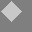

In [110]:
sof_image

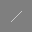

In [111]:
just_oriented_edge

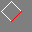

In [112]:
surface_oriented_edge

### Bg image with RF marked

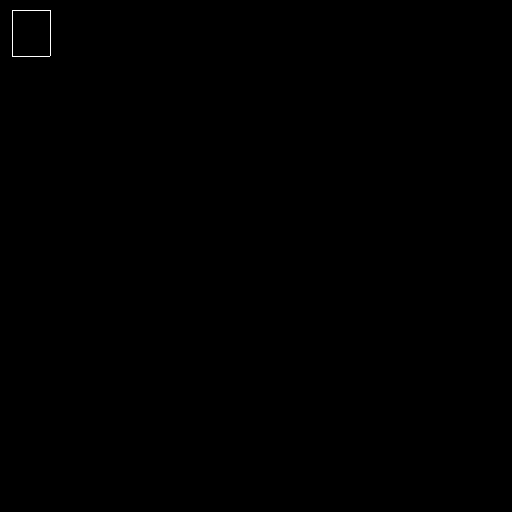

In [113]:
bg_image=np.zeros((512,512))


top=10
bottom=56
left=12
right=50

bg_image[top,left:right]=255.0
bg_image[bottom,left:right]=255.0

bg_image[top:bottom,left]=255.0
bg_image[top:bottom,right]=255.0

bg_image=bg_image.astype(np.uint8)
display(Image.fromarray(bg_image))

### Embedding the SOF image in the big image

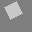

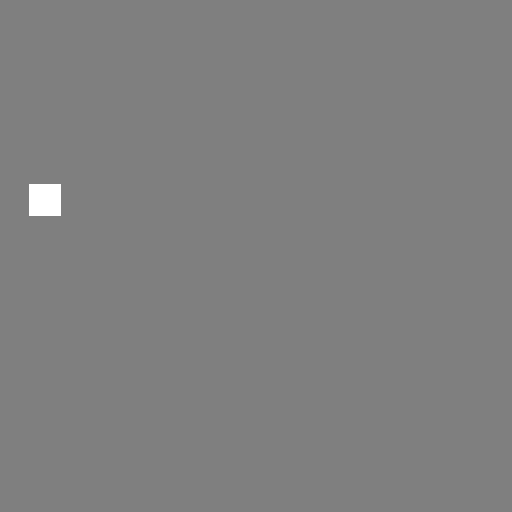

In [114]:
sof_image,_,_=get_sof_complete(readable_orientation=23)
display(sof_image)
bg_image=np.zeros((512,512))

final_image = embed_norm(np.array(sof_image),bg_image, 45 - (sof_image.size[0] // 2), 200 - (sof_image.size[1] // 2))

final_image

### Just an interactive version of the above

In [115]:
@interact(image_size=(32,300,2),readable_orientation=(0,90),edge_length=(10,30),polygon_sides=(4,8,1),side_fig=['left','right'],big_image_size=(200,512),
         xpos=(100,300),ypos=(100,300))
def vis_figure(image_size=32,readable_orientation=45,edge_length=10,polygon_sides=4,side_fig='left',big_image_size=512,xpos=100,ypos=100):
    
    orientation=360-readable_orientation
    image_center=(image_size//2,image_size//2)

    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)
        
        
    edges=[]
    
    image = Image.new('L', (image_size, image_size), 0)
    draw = ImageDraw.Draw(image)
    
    
    
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    draw.polygon(edges,fill=255)
    display(image)
    
    
    
    
    bg_image=np.zeros((big_image_size,big_image_size))
    
    startX=xpos - (image_size//2)
    startY=ypos - (image_size//2)
    
    
    ## SOF image
    bg_image[startY,startX:startX + image_size]=255
    bg_image[startY + image_size,startX:startX + image_size]=255
    bg_image[startY:startY + image_size,startX]=255
    bg_image[startY:startY + image_size,startX + image_size]=255
    
    
    # final_image = embed_norm(np.array(image),bg_image, xpos, ypos)
    final_image = embed_norm(np.array(image),bg_image, startX, startY)
    
    display(final_image)
    
    
    
    

interactive(children=(IntSlider(value=32, description='image_size', max=300, min=32, step=2), IntSlider(value=…

# Part B: Load actual RF location and orientation pref tuning for a specific DNN layer

In [558]:
orientation_rf_matrix=np.load('./rf_orientatation_values/'+current_layer.replace('.','_') + '.npy')
orientation_rf_matrix.shape

(63, 63, 196)

In [563]:
@interact(row_pos=(0,orientation_rf_matrix.shape[0]-1),col_pos=(0,orientation_rf_matrix.shape[1]-1))
def analytical_rf(row_pos,col_pos):

    activation_map=np.zeros((orientation_rf_matrix.shape[0],orientation_rf_matrix.shape[1]))
    activation_map[(row_pos,col_pos)]=1.0


    plt.figure(figsize=(12,12))
    sns.heatmap(activation_map,linewidths=0.01,cbar=False)
    
    top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)

interactive(children=(IntSlider(value=31, description='row_pos', max=62), IntSlider(value=31, description='col…

In [564]:
@interact(image_size=(32,300,2),readable_orientation=(0,90),edge_length=(10,30),polygon_sides=(4,8,1),side_fig=['left','right'],big_image_size=(200,512),
         xpos=(0,300),ypos=(0,300))
def vis_figure(image_size=32,readable_orientation=45,edge_length=10,polygon_sides=4,side_fig='left',big_image_size=512,xpos=100,ypos=100):
    
    row_pos=int(orientation_rf_matrix.shape[0] / 2)
    col_pos=int(orientation_rf_matrix.shape[1] / 2)
    top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)
    
    
    orientation=360-readable_orientation
    image_center=(image_size//2,image_size//2)

    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)
        
        
    edges=[]
    
    image = Image.new('L', (image_size, image_size), 0)
    draw = ImageDraw.Draw(image)
    
    
    
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    draw.polygon(edges,fill=255)
    display(image)
    
    
    
    
    bg_image=np.zeros((big_image_size,big_image_size))
    
    startX=xpos - (image_size//2)
    startY=ypos - (image_size//2)
    
    
    ## SOF image locations
    bg_image[startY,startX:startX + image_size]=255
    bg_image[startY + image_size,startX:startX + image_size]=255
    bg_image[startY:startY + image_size,startX]=255
    bg_image[startY:startY + image_size,startX + image_size]=255
    
    ## RF LOCATIONS
    bg_image[top,left:right]=255
    bg_image[bottom,left:right]=255.0

    bg_image[top:bottom,left]=255.0
    bg_image[top:bottom,right]=255.0
    
    
    # final_image = embed_norm(np.array(image),bg_image, xpos, ypos)
    final_image = embed_norm(np.array(image),bg_image, startX, startY)
    
    display(final_image)
    
    
    
    

interactive(children=(IntSlider(value=32, description='image_size', max=300, min=32, step=2), IntSlider(value=…

### just extra

In [578]:
@interact(row_pos=(0,orientation_rf_matrix.shape[0]-1),col_pos=(0,orientation_rf_matrix.shape[1]-1))
def analytical_rf(row_pos,col_pos):

    activation_map=np.zeros((orientation_rf_matrix.shape[0],orientation_rf_matrix.shape[1]))
    activation_map[(row_pos,col_pos)]=1.0


    plt.figure(figsize=(4,4))
    sns.heatmap(activation_map,linewidths=0.0,cbar=False)
    
    top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)

interactive(children=(IntSlider(value=31, description='row_pos', max=62), IntSlider(value=31, description='col…

In [581]:
@interact(image_size=(32,300,2),readable_orientation=(0,90),edge_length=(10,30),polygon_sides=(4,8,1),side_fig=['left','right'],big_image_size=(200,512),
         xpos=(0,300),ypos=(0,300))
def vis_figure(image_size=32,readable_orientation=45,edge_length=10,polygon_sides=4,side_fig='left',big_image_size=512,xpos=100,ypos=100):
    
    row_pos=46
    col_pos=46
    top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)
    
    
    orientation=360-readable_orientation
    image_center=(image_size//2,image_size//2)

    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)
        
        
    edges=[]
    
    image = Image.new('L', (image_size, image_size), 0)
    draw = ImageDraw.Draw(image)
    
    
    
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    # draw.polygon(edges,fill=255)
    # display(image)
    
    
    
    
    bg_image=np.zeros((big_image_size,big_image_size))
    
    startX=xpos - (image_size//2)
    startY=ypos - (image_size//2)
    
    
    ## SOF image locations
    # bg_image[startY,startX:startX + image_size]=255
    # bg_image[startY + image_size,startX:startX + image_size]=255
    # bg_image[startY:startY + image_size,startX]=255
    # bg_image[startY:startY + image_size,startX + image_size]=255
    
    ## RF LOCATIONS
    bg_image[top,left:right]=255
    bg_image[bottom,left:right]=255.0

    bg_image[top:bottom,left]=255.0
    bg_image[top:bottom,right]=255.0
    
    
    # final_image = embed_norm(np.array(image),bg_image, xpos, ypos)
    final_image = embed_norm(np.array(image),bg_image, startX, startY)
    
    display(final_image)
    
    
    
    

interactive(children=(IntSlider(value=32, description='image_size', max=300, min=32, step=2), IntSlider(value=…

### Adding the SOF systematically within the RF, orientation can be changed manually but will show the distribution of orientation preferences

In [582]:
@interact(row_pos=(0,orientation_rf_matrix.shape[0]-1),col_pos=(0,orientation_rf_matrix.shape[1]-1),multiplier_image_size=(1.0,4.0,0.5),multiplier_surface_size=(2.0,5.0,0.5))
def analytical_rf(row_pos,col_pos,multiplier_image_size=2.5,multiplier_surface_size=4.0):

    activation_map=np.zeros((orientation_rf_matrix.shape[0],orientation_rf_matrix.shape[1]))
    activation_map[(row_pos,col_pos)]=1.0


    plt.figure(figsize=(12,12))
    sns.heatmap(activation_map,linewidths=0.01,cbar=False)
    plt.show()
    
    top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)
    filter_otientatation_pref=orientation_rf_matrix[(row_pos,col_pos)][4:]
    
    
    plt.figure(figsize=(10,4))
    plt.hist(filter_otientatation_pref, bins=90, range=(0,180), alpha=0.5)
    plt.show()
    
    print(top,bottom,left,right)
    
    if(top==512):
        top-=1
    
    if(bottom==512):
        bottom-=1
    
    if(left==512):
        left-=1
    
    if(right==512):
        right-=1
    
    

    @interact(image_size=(32,300,2),readable_orientation=(0,90),edge_length=(10,100),polygon_sides=(4,8,1),side_fig=['left','right'],big_image_size=(200,512),xpos=(0,512),ypos=(0,512))
    def vis_figure(image_size=int((bottom-top)*multiplier_image_size),
                   readable_orientation=45,edge_length=10*multiplier_surface_size,
                   polygon_sides=4,side_fig='left',big_image_size=512,
                   ypos=top + (bottom-top)/2 ,xpos=left + (right-left)/2):

        orientation=360-readable_orientation
        image_center=(image_size//2,image_size//2)

        if(side_fig=='left'):
            polygon_angle=(1)*(180-360//polygon_sides)
        elif(side_fig=='right'):
            polygon_angle=(-1)*(180-360//polygon_sides)


        edges=[]

        image = Image.new('L', (image_size, image_size), 0)
        draw = ImageDraw.Draw(image)



        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

        for point in range(polygon_sides-2):
            fulcrum=edges[-1]
            rotating_point=edges[-2]
            new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
            edges.append(new_point)

        draw.polygon(edges,fill=255)
        display(image)




        bg_image=np.zeros((big_image_size,big_image_size))

        startX=int(xpos - (image_size//2))
        startY=int(ypos - (image_size//2))
        assert startX>0 and startY>0


        ## SOF image locations
        bg_image[startY,startX:startX + image_size]=255
        bg_image[startY + image_size,startX:startX + image_size]=255
        bg_image[startY:startY + image_size,startX]=255
        bg_image[startY:startY + image_size,startX + image_size]=255

        ## RF LOCATIONS
        bg_image[top,left:right]=255
        bg_image[bottom,left:right]=255.0

        bg_image[top:bottom,left]=255.0
        bg_image[top:bottom,right]=255.0


        # final_image = embed_norm(np.array(image),bg_image, xpos, ypos)
        final_image = embed_norm(np.array(image),bg_image, startX, startY)

        display(final_image)
    
    
    
    

interactive(children=(IntSlider(value=31, description='row_pos', max=62), IntSlider(value=31, description='col…

### Only fill classical RF region

In [562]:
@interact(row_pos=(0,orientation_rf_matrix.shape[0]-1),col_pos=(0,orientation_rf_matrix.shape[1]-1),multiplier_image_size=(1.0,4.0,0.5),multiplier_surface_size=(2.0,5.0,0.5))
def analytical_rf(row_pos,col_pos,multiplier_image_size=2.5,multiplier_surface_size=4.0):

    activation_map=np.zeros((orientation_rf_matrix.shape[0],orientation_rf_matrix.shape[1]))
    activation_map[(row_pos,col_pos)]=1.0


    plt.figure(figsize=(12,12))
    sns.heatmap(activation_map,linewidths=0.01,cbar=False)
    plt.show()
    
    top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)
    filter_otientatation_pref=orientation_rf_matrix[(row_pos,col_pos)][4:]
    
    
    plt.figure(figsize=(10,4))
    plt.hist(filter_otientatation_pref, bins=90, range=(0,180), alpha=0.5)
    plt.show()
    
    print(top,bottom,left,right)
    
    if(top==512):
        top-=1
    
    if(bottom==512):
        bottom-=1
    
    if(left==512):
        left-=1
    
    if(right==512):
        right-=1
    
    

    @interact(image_size=(32,300,2),readable_orientation=(0,90),edge_length=(10,100),polygon_sides=(4,8,1),side_fig=['left','right'],big_image_size=(200,512),xpos=(0,512),ypos=(0,512))
    def vis_figure(image_size=int((bottom-top)*multiplier_image_size),
                   readable_orientation=45,edge_length=10*multiplier_surface_size,
                   polygon_sides=4,side_fig='left',big_image_size=512,
                   ypos=top + (bottom-top)/2 ,xpos=left + (right-left)/2):

        orientation=360-readable_orientation
        image_center=(image_size//2,image_size//2)

        if(side_fig=='left'):
            polygon_angle=(1)*(180-360//polygon_sides)
        elif(side_fig=='right'):
            polygon_angle=(-1)*(180-360//polygon_sides)


        edges=[]

        image = Image.new('L', (image_size, image_size), 0)
        draw = ImageDraw.Draw(image)



        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

        for point in range(polygon_sides-2):
            fulcrum=edges[-1]
            rotating_point=edges[-2]
            new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
            edges.append(new_point)

        draw.polygon(edges,fill=255)
        display(image)



        
        ############################################################
        bg_image=np.zeros((big_image_size,big_image_size))

        startX=int(xpos - (image_size//2))
        startY=int(ypos - (image_size//2))
        assert startX>0 and startY>0


        ## SOF image locations
        bg_image[startY,startX:startX + image_size]=255
        bg_image[startY + image_size,startX:startX + image_size]=255
        bg_image[startY:startY + image_size,startX]=255
        bg_image[startY:startY + image_size,startX + image_size]=255

        # RF LOCATIONS
        bg_image[top,left:right]=255
        bg_image[bottom,left:right]=255.0

        bg_image[top:bottom,left]=255.0
        bg_image[top:bottom,right]=255.0
        final_image = embed_norm(np.array(image),bg_image, startX, startY)
        display(final_image)
        ############################################################
        

        
        
        
        ############################################################
        bg_image=np.zeros((big_image_size,big_image_size))

        startX=int(xpos - (image_size//2))
        startY=int(ypos - (image_size//2))
        assert startX>0 and startY>0
        
        
        # RF LOCATIONS
        bg_image[top,left:right]=255
        bg_image[bottom,left:right]=255.0

        bg_image[top:bottom,left]=255.0
        bg_image[top:bottom,right]=255.0
        
        final_image = embed_norm(np.array(image),bg_image, startX, startY)
        display(final_image)
        ############################################################
        
        
        
        ############################################################
        bg_image=np.zeros((big_image_size,big_image_size))

        startX=int(xpos - (image_size//2))
        startY=int(ypos - (image_size//2))
        assert startX>0 and startY>0
        
        final_image = embed_norm(np.array(image),bg_image, startX, startY)
        display(final_image)
        ############################################################
        
        
        
        ############################################################
        bg_image=np.zeros((big_image_size,big_image_size))

        startX=int(xpos - (image_size//2))
        startY=int(ypos - (image_size//2))
        assert startX>0 and startY>0
        
        rf_mask=np.zeros((big_image_size,big_image_size))
        rf_mask[top:bottom,left:right]=1.0
        final_image = embed_norm_mask(np.array(image),bg_image, startX, startY,rf_mask)
        display(final_image)
        ############################################################

        

    
    
    
    

interactive(children=(IntSlider(value=31, description='row_pos', max=62), IntSlider(value=31, description='col…

# Using the above to make stimuli for all the channels after selecting a specific position

### For one example unit and one filter/orientation value

In [127]:
row_pos=int(orientation_rf_matrix.shape[0] / 2)
col_pos=int(orientation_rf_matrix.shape[1] / 2)
filter_val=3

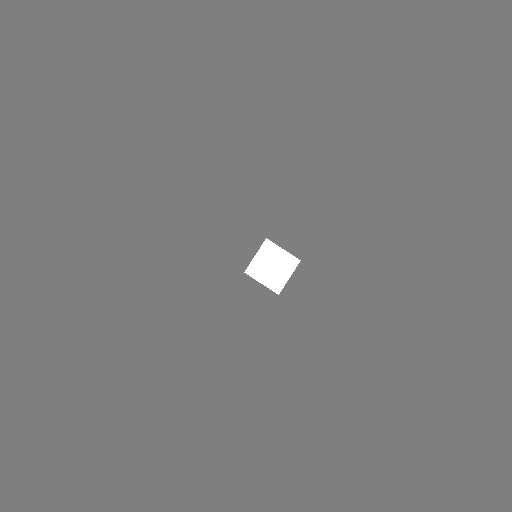

In [128]:
top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)
readable_orientation=orientation_rf_matrix[(row_pos,col_pos)][4:][filter_val]

orientation=360-readable_orientation
image_size=int((bottom-top)*2.5)
edge_length=40
polygon_sides=4
side_fig='right'
big_image_size=512
ypos=top + (bottom-top)/2 
xpos=left + (right-left)/2



orientation=360-readable_orientation
image_center=(image_size//2,image_size//2)

if(side_fig=='left'):
    polygon_angle=(1)*(180-360//polygon_sides)
elif(side_fig=='right'):
    polygon_angle=(-1)*(180-360//polygon_sides)


edges=[]

image = Image.new('L', (image_size, image_size), 0)
draw = ImageDraw.Draw(image)



edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

for point in range(polygon_sides-2):
    fulcrum=edges[-1]
    rotating_point=edges[-2]
    new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
    edges.append(new_point)

draw.polygon(edges,fill=255)



bg_image=np.zeros((big_image_size,big_image_size))

startX=int(xpos - (image_size//2))
startY=int(ypos - (image_size//2))

assert startX>0 and startY>0

# final_image = embed_norm(np.array(image),bg_image, xpos, ypos)
final_image = embed_norm(np.array(image),bg_image, startX, startY)

display(final_image)

### images for all filters and all positions - this seems a lot of images though so cancel for now

In [129]:
# all_left_images=[]
# all_right_images=[]

# for readable_orientation in tqdm(orientation_rf_matrix[0,0,4:]):
#     all_left_images_currentorient=[]
#     all_right_images_currentorient=[]
    
#     for row_pos in range(orientation_rf_matrix.shape[0]):
#         for col_pos in range(orientation_rf_matrix.shape[1]):
            
#             top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)
    

#             orientation=360-readable_orientation
#             image_size=int((bottom-top)*2.5)
#             edge_length=10 * 4.0
#             polygon_sides=4

#             big_image_size=512
#             ypos=top + (bottom-top)/2 
#             xpos=left + (right-left)/2


#             image_center=(image_size//2,image_size//2)
            
            
            
            
#             try:
#                 startX=int(xpos - (image_size//2))
#                 startY=int(ypos - (image_size//2))
#                 assert startX>0 and startY>0
                
                
#                 ########################################################################################################################
#                 side_fig='left'
#                 if(side_fig=='left'):
#                     polygon_angle=(1)*(180-360//polygon_sides)
#                 elif(side_fig=='right'):
#                     polygon_angle=(-1)*(180-360//polygon_sides)


                
#                 image = Image.new('L', (image_size, image_size), 0)
#                 draw = ImageDraw.Draw(image)


#                 edges=[]
#                 edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
#                 edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))
#                 for point in range(polygon_sides-2):
#                     fulcrum=edges[-1]
#                     rotating_point=edges[-2]
#                     new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
#                     edges.append(new_point)
#                 draw.polygon(edges,fill=255)
#                 bg_image=np.zeros((big_image_size,big_image_size))

#                 left_image = embed_norm(np.array(image),bg_image, startX, startY)
#                 all_left_images_currentorient.append(left_image)
#                 ########################################################################################################################
                
#                 ########################################################################################################################
#                 side_fig='right'
#                 if(side_fig=='left'):
#                     polygon_angle=(1)*(180-360//polygon_sides)
#                 elif(side_fig=='right'):
#                     polygon_angle=(-1)*(180-360//polygon_sides)


                
#                 image = Image.new('L', (image_size, image_size), 0)
#                 draw = ImageDraw.Draw(image)


#                 edges=[]
#                 edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
#                 edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))
#                 for point in range(polygon_sides-2):
#                     fulcrum=edges[-1]
#                     rotating_point=edges[-2]
#                     new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
#                     edges.append(new_point)
#                 draw.polygon(edges,fill=255)
#                 bg_image=np.zeros((big_image_size,big_image_size))

#                 right_image = embed_norm(np.array(image),bg_image, startX, startY)
#                 all_right_images_currentorient.append(right_image)
#                 ########################################################################################################################
                
#             except AssertionError:
#                 pass
            

#     all_left_images.append(all_left_images_currentorient)
#     all_right_images.append(all_right_images_currentorient)

# Let's instead focus on just one unit position but all orientations

In [130]:
global_row_pos=None
global_col_pos=None
@interact(row_pos=(0,orientation_rf_matrix.shape[0]-1),col_pos=(0,orientation_rf_matrix.shape[0]-1))
def analytical_rf(row_pos,col_pos,multiplier_image_size=1.0,multiplier_surface_size=2.0):
    global global_row_pos
    global global_col_pos
    activation_map=np.zeros((orientation_rf_matrix.shape[0],orientation_rf_matrix.shape[1]))
    activation_map[(row_pos,col_pos)]=1.0


    plt.figure(figsize=(12,12))
    sns.heatmap(activation_map,linewidths=0.01,cbar=False)
    plt.show()
    
    global_row_pos=row_pos
    global_col_pos=col_pos

interactive(children=(IntSlider(value=31, description='row_pos', max=62), IntSlider(value=31, description='col…

In [175]:
print(global_row_pos)
print(global_col_pos)

36
24


In [176]:
all_images=[]

for readable_orientation in tqdm(orientation_rf_matrix[0,0,4:]):
    top,bottom,left,right =orientation_rf_matrix[(global_row_pos,global_col_pos)][:4].astype(np.int64)
    

    orientation=360-readable_orientation
    image_size=int((bottom-top)*2.5)
    edge_length=10 * 4.0
    polygon_sides=4
    
    big_image_size=512
    ypos=top + (bottom-top)/2 
    xpos=left + (right-left)/2




    image_center=(image_size//2,image_size//2)
    
    ##########################################################################################
    ##### Left image
    side_fig='left'
    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)


    edges=[]

    image = Image.new('L', (image_size, image_size), 0)
    draw = ImageDraw.Draw(image)



    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    draw.polygon(edges,fill=255)



    bg_image=np.zeros((big_image_size,big_image_size))

    startX=int(xpos - (image_size//2))
    startY=int(ypos - (image_size//2))
    assert startX>0 and startY>0

    # final_image = embed_norm(np.array(image),bg_image, xpos, ypos)
    left_final_image = embed_norm(np.array(image),bg_image, startX, startY)
    ##########################################################################################
    
    
    ##########################################################################################
    ##### Right image
    side_fig='right'
    if(side_fig=='left'):
        polygon_angle=(1)*(180-360//polygon_sides)
    elif(side_fig=='right'):
        polygon_angle=(-1)*(180-360//polygon_sides)


    edges=[]

    image = Image.new('L', (image_size, image_size), 0)
    draw = ImageDraw.Draw(image)



    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
    edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

    for point in range(polygon_sides-2):
        fulcrum=edges[-1]
        rotating_point=edges[-2]
        new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
        edges.append(new_point)

    draw.polygon(edges,fill=255)



    bg_image=np.zeros((big_image_size,big_image_size))

    startX=int(xpos - (image_size//2))
    startY=int(ypos - (image_size//2))
    assert startX>0 and startY>0

    

    # final_image = embed_norm(np.array(image),bg_image, xpos, ypos)
    right_final_image = embed_norm(np.array(image),bg_image, startX, startY)
    ##########################################################################################
    

    all_images.append([left_final_image,right_final_image])
    
    
all_images=np.array(all_images)  
    
    
    

  0%|          | 0/192 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [177]:
@interact(img_num=(0,len(all_images)-1))
def display_image(img_num):
    display(all_images[img_num][0])
    display(all_images[img_num][1])

interactive(children=(IntSlider(value=95, description='img_num', max=191), Output()), _dom_classes=('widget-in…

# Part C: Showing these images to the DNN and recording activity from the DNN units

In [178]:
# normalize images using parameters from the training image set
image_transform= transforms.Compose([       
 transforms.Resize(256),transforms.Pad(128),
 transforms.CenterCrop((512,512)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225])])

In [179]:
@interact(img_num=(0,len(all_images)-1))
def display_image(img_num):
    
    display(all_images[img_num][0])
    img_left=image_transform(all_images[img_num][0].convert('RGB'))
    img_left=img_left.to(device)
    img_left=torch.unsqueeze(img_left,0)
    print('Left image',img_left.shape)
    
    
    
    display(all_images[img_num][1])
    img_right=image_transform(all_images[img_num][1].convert('RGB'))
    img_right=img_right.to(device)
    img_right=torch.unsqueeze(img_right,0)
    print('Right image',img_right.shape)
    
    


interactive(children=(IntSlider(value=95, description='img_num', max=191), Output()), _dom_classes=('widget-in…

### passing these images and getting features

In [180]:
base_model=pretrained_models.alexnet(pretrained=True)
base_model.eval()

base_model=base_model.to(device)

In [181]:
@interact(img_num=(0,len(all_images)-1))
def display_image(img_num):
    

    img_left=image_transform(all_images[img_num][0].convert('RGB'))
    img_left=img_left.to(device)
    img_left=torch.unsqueeze(img_left,0)

    
    
    

    img_right=image_transform(all_images[img_num][1].convert('RGB'))
    img_right=img_right.to(device)
    img_right=torch.unsqueeze(img_right,0)

    
    
    
    
    
    with FeatureExtractor(base_model, current_layer) as extractor:
        features = extractor(torch.cat((img_left,img_right),0))
        temp_output=features[current_layer]
        
        
        output=torch.clone(temp_output.detach().cpu())
        
        output=output[:,img_num,global_row_pos,global_col_pos]
        print(output)
        

interactive(children=(IntSlider(value=95, description='img_num', max=191), Output()), _dom_classes=('widget-in…

# Part D - Combining Part B and Part C

In [583]:
orientation_rf_matrix=np.load('./rf_orientatation_values/'+current_layer.replace('.','_') + '.npy')
orientation_rf_matrix.shape

(63, 63, 196)

In [584]:
# normalize images using parameters from the training image set
image_transform= transforms.Compose([       
 transforms.Resize(256),transforms.Pad(128),
 transforms.CenterCrop((512,512)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225])])

In [585]:
base_model=pretrained_models.alexnet(pretrained=True)
base_model.eval()

base_model=base_model.to(device)

In [586]:
def get_sof_images_pos(row_pos,col_pos):
    all_images=[]

    for readable_orientation in tqdm(orientation_rf_matrix[0,0,4:],disable=True):
        top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)


        orientation=360-readable_orientation
        image_size=int((bottom-top)*2.5)
        edge_length=10 * 4.0
        polygon_sides=4

        big_image_size=512
        ypos=top + (bottom-top)/2 
        xpos=left + (right-left)/2




        image_center=(image_size//2,image_size//2)

        ##########################################################################################
        ##### Left image
        side_fig='left'
        if(side_fig=='left'):
            polygon_angle=(1)*(180-360//polygon_sides)
        elif(side_fig=='right'):
            polygon_angle=(-1)*(180-360//polygon_sides)


        edges=[]

        image = Image.new('L', (image_size, image_size), 0)
        draw = ImageDraw.Draw(image)



        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

        for point in range(polygon_sides-2):
            fulcrum=edges[-1]
            rotating_point=edges[-2]
            new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
            edges.append(new_point)

        draw.polygon(edges,fill=255)



        bg_image=np.zeros((big_image_size,big_image_size))

        startX=int(xpos - (image_size//2))
        startY=int(ypos - (image_size//2))
        assert startX>0 and startY>0

        
        left_final_image = embed_norm(np.array(image),bg_image, startX, startY)
        ##########################################################################################


        ##########################################################################################
        ##### Right image
        side_fig='right'
        if(side_fig=='left'):
            polygon_angle=(1)*(180-360//polygon_sides)
        elif(side_fig=='right'):
            polygon_angle=(-1)*(180-360//polygon_sides)


        edges=[]

        image = Image.new('L', (image_size, image_size), 0)
        draw = ImageDraw.Draw(image)



        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

        for point in range(polygon_sides-2):
            fulcrum=edges[-1]
            rotating_point=edges[-2]
            new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
            edges.append(new_point)

        draw.polygon(edges,fill=255)



        bg_image=np.zeros((big_image_size,big_image_size))

        startX=int(xpos - (image_size//2))
        startY=int(ypos - (image_size//2))
        assert startX>0 and startY>0



        
        right_final_image = embed_norm(np.array(image),bg_image, startX, startY)
        ##########################################################################################


        all_images.append([left_final_image,right_final_image])


    all_images=np.array(all_images)  
    return all_images
    
    
    

In [587]:
def get_activity_pos(all_images,img_num,row_pos,col_pos):
    img_left=image_transform(all_images[img_num][0].convert('RGB'))
    img_left=img_left.to(device)
    img_left=torch.unsqueeze(img_left,0)





    img_right=image_transform(all_images[img_num][1].convert('RGB'))
    img_right=img_right.to(device)
    img_right=torch.unsqueeze(img_right,0)






    with FeatureExtractor(base_model, current_layer) as extractor:
        features = extractor(torch.cat((img_left,img_right),0))
        temp_output=features[current_layer]


        output=torch.clone(temp_output.detach().cpu())

        output=output[:,img_num,row_pos,col_pos]
        return output

In [588]:
def analyse_position(row_pos=31,col_pos=31):
    
    try:
        all_images=get_sof_images_pos(row_pos,col_pos)

        all_outputs=[]
        for img_num in range(all_images.shape[0]):
            output=get_activity_pos(all_images,img_num,row_pos,col_pos)
            all_outputs.append(output)
        all_outputs=torch.stack(all_outputs)
        return all_outputs,(row_pos,col_pos)
    
    
    except AssertionError:
        return None,None

In [592]:
analyse_position(0,26)

(None, None)

In [593]:
all_outputs,map_pos=analyse_position(0,26)

In [594]:
probe_pos=[]
probe_output=[]
for row_pos in range(20,40):
    for col_pos in range(20,40):
        all_outputs,map_pos=analyse_position(row_pos,col_pos)
        if(all_outputs!=None):
            probe_output.append(all_outputs)
            probe_pos.append(map_pos)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:107: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [597]:
probe_pos=np.array(probe_pos)
probe_output=torch.stack(probe_output)

In [598]:
probe_pos.shape

(400, 2)

In [599]:
probe_output.shape

torch.Size([400, 192, 2])

In [600]:
# torch.save(probe_output,'./sof_values/'+current_layer.replace('.','_') + '.npy')

In [653]:
probe_diff=np.abs(probe_output[:,:,0] - probe_output[:,:,1])

In [654]:
probe_diff[-1]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5799e+00, 6.0747e-02,
        0.0000e+00, 0.0000e+00, 1.7343e-01, 0.0000e+00, 7.3224e-01, 0.0000e+00,
        1.0152e-01, 9.2033e-01, 0.0000e+00, 4.0945e-02, 0.0000e+00, 1.1913e-01,
        2.0695e+00, 3.8411e-01, 2.5929e+00, 2.4822e-02, 2.0888e-01, 0.0000e+00,
        5.3937e-02, 5.9451e-02, 8.7705e-02, 3.8462e-02, 0.0000e+00, 4.6269e-02,
        0.0000e+00, 2.1076e-01, 3.1237e-03, 0.0000e+00, 3.1661e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0457e-02, 0.0000e+00, 2.0745e-01, 3.7610e-01,
        7.9022e-02, 2.2345e-02, 0.0000e+00, 8.5334e-01, 1.7347e-02, 0.0000e+00,
        2.1127e-01, 0.0000e+00, 0.0000e+00, 1.3731e+00, 2.8479e-02, 2.5263e-01,
        0.0000e+00, 1.6876e-02, 0.0000e+00, 0.0000e+00, 5.9260e-02, 6.7717e-01,
        3.6900e-01, 0.0000e+00, 4.9606e-02, 1.0031e+00, 4.7925e-02, 0.0000e+00,
        6.7711e-02, 1.0091e-02, 9.9171e-03, 0.0000e+00, 7.6915e-01, 1.4448e-01,
        0.0000e+00, 5.0633e+00, 0.0000e+

In [655]:
probe_diff.shape

torch.Size([400, 192])

In [656]:
probe_diff=np.transpose(probe_diff)

In [657]:
probe_diff.shape

torch.Size([192, 400])

In [662]:
torch.mean(probe_diff[0,:])

tensor(0.4280)

In [693]:
probe_diff_percentage=[]
probe_diff_mean=[]
probe_diff_std=[]
for i in range(probe_diff.shape[0]):
    probe_diff_percentage.append(len(np.where(probe_diff[i,:]!=0)[0])/float(probe_diff[i,:].shape[0]))
    probe_diff_mean.append(torch.mean(probe_diff[i,:]).item())
    probe_diff_std.append(torch.std(probe_diff[i,:]).item())
    
probe_diff_percentage=np.array(probe_diff_percentage)
probe_diff_mean=np.array(probe_diff_mean)
probe_diff_std=np.array(probe_diff_std)

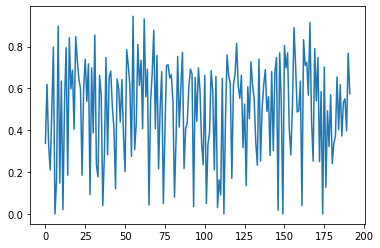

In [694]:
plt.plot(np.arange(len(probe_diff_percentage)),probe_diff_percentage)

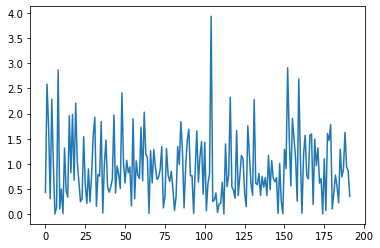

In [695]:
plt.plot(np.arange(len(probe_diff_mean)),probe_diff_mean)

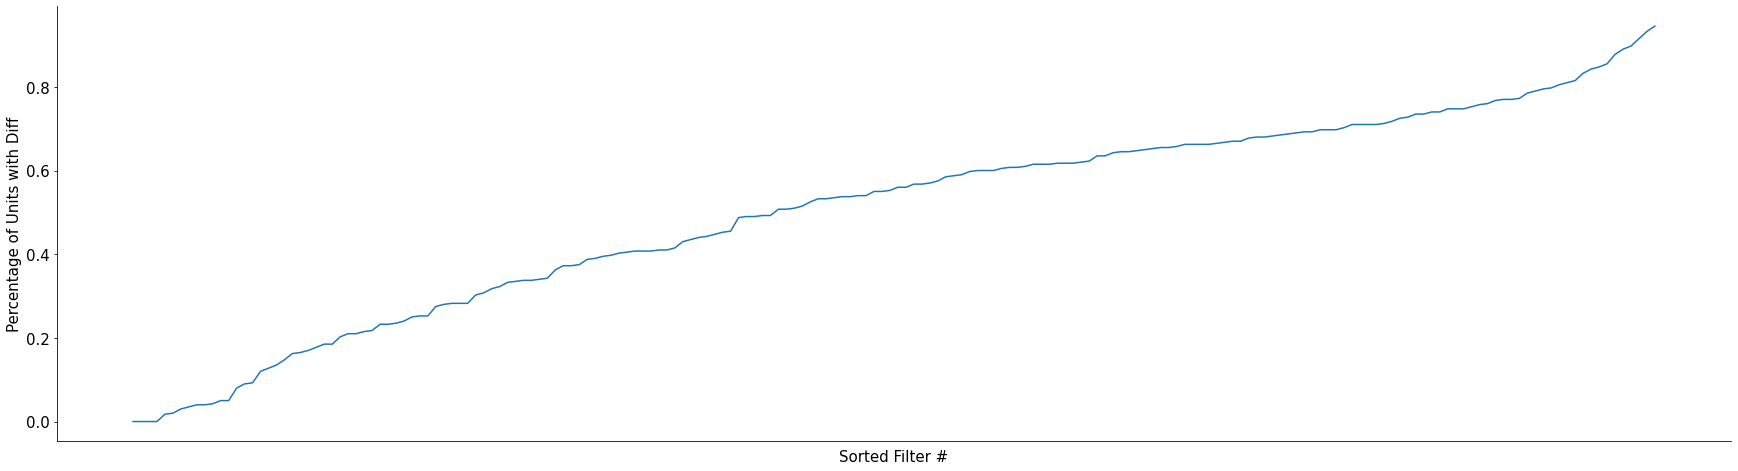

In [710]:

sort_idx=np.argsort(probe_diff_percentage)
probe_diff_percentage=probe_diff_percentage[sort_idx]
len(probe_diff_percentage)

plt.figure(figsize=(30,8))
# plt.bar(np.arange(len(probe_diff_percentage)),probe_diff_percentage)
plt.plot(np.arange(len(probe_diff_percentage)),probe_diff_percentage)
plt.xticks([],fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Sorted Filter #',fontsize=15)
plt.ylabel('Percentage of Units with Diff',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

In [697]:
len(np.where(probe_diff_percentage>0.6)[0])

83

In [711]:
sort_idx=np.argsort(probe_diff_mean)
probe_diff_mean=probe_diff_mean[sort_idx]
probe_diff_std=probe_diff_std[sort_idx]
len(probe_diff_percentage)

192

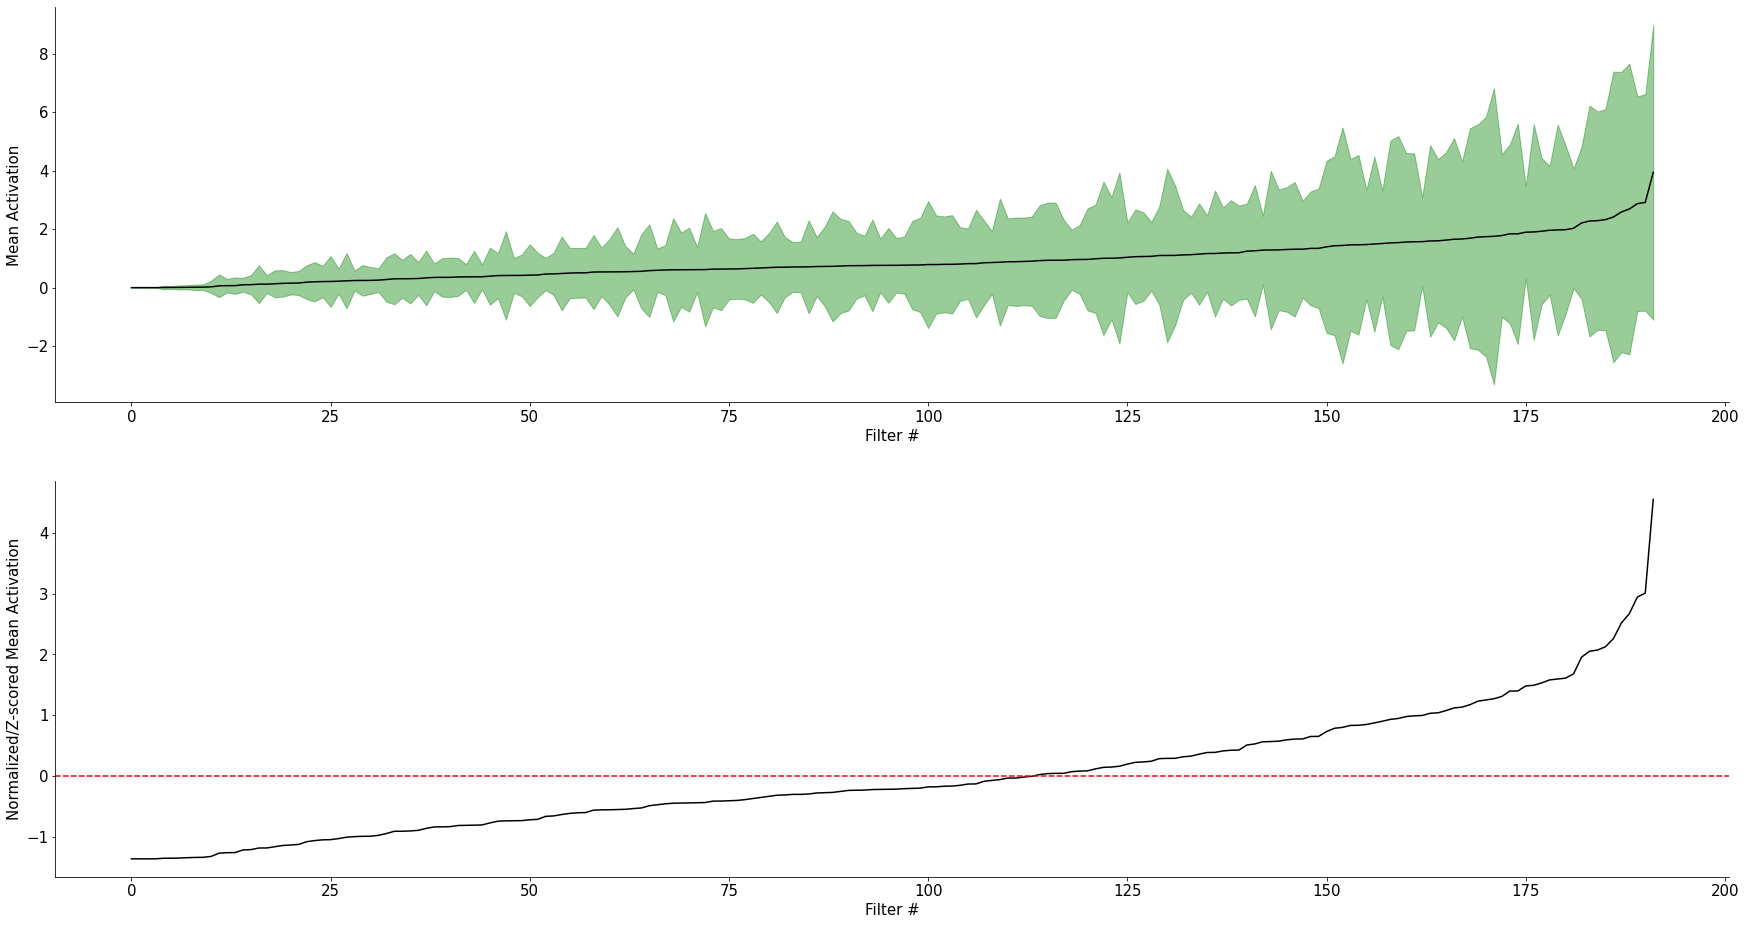

In [716]:
plt.figure(figsize=(30,16))

plt.subplot(2,1,1)
plt.plot(np.arange(len(probe_diff_mean)),probe_diff_mean,color='k')
plt.fill_between(np.arange(len(probe_diff_mean)),probe_diff_mean - probe_diff_std,probe_diff_mean + probe_diff_std,alpha=0.4,color='green')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Filter #',fontsize=15)
plt.ylabel('Mean Activation',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

plt.subplot(2,1,2)
plt.plot(np.arange(len(probe_diff_mean)),(probe_diff_mean-np.mean(probe_diff_mean))/(np.std(probe_diff_mean)),color='k')
plt.axhline(y=0,color='r',linestyle='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Filter #',fontsize=15)
plt.ylabel('Normalized/Z-scored Mean Activation',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

In [651]:
probe_diff.shape

torch.Size([192, 400])

In [331]:
print((probe_diff==torch.max(probe_diff)).nonzero())

tensor([[1509,  127]])


In [340]:
torch.sum(probe_diff != 0) / float(len(probe_diff.view(-1,)))

tensor(0.0838)

In [148]:
@interact(img_num=(0,len(all_images)-1))
def display_image(img_num):
    

    img_left=image_transform(all_images[img_num][0].convert('RGB'))
    img_left=img_left.to(device)
    img_left=torch.unsqueeze(img_left,0)

    
    
    

    img_right=image_transform(all_images[img_num][1].convert('RGB'))
    img_right=img_right.to(device)
    img_right=torch.unsqueeze(img_right,0)

    
    
    
    
    
    with FeatureExtractor(base_model, current_layer) as extractor:
        features = extractor(torch.cat((img_left,img_right),0))
        temp_output=features[current_layer]
        
        
        output=torch.clone(temp_output.detach().cpu())
        
        output=output[:,img_num,global_row_pos,global_col_pos]
        print(output)
        

interactive(children=(IntSlider(value=95, description='img_num', max=191), Output()), _dom_classes=('widget-in…

# Part E - Is this because of the left over portion in the classical RF?

In [717]:
orientation_rf_matrix=np.load('./rf_orientatation_values/'+current_layer.replace('.','_') + '.npy')
orientation_rf_matrix.shape

(63, 63, 196)

In [718]:
# # normalize images using parameters from the training image set
# image_transform= transforms.Compose([       
#  transforms.Resize(256),transforms.Pad(128),
#  transforms.CenterCrop((512,512)),         
#  transforms.ToTensor(),                    
#  transforms.Normalize(                      
#  mean=[0.485, 0.456, 0.406],                
#  std=[0.229, 0.224, 0.225])])

In [719]:
# normalize images using parameters from the training image set
image_transform= transforms.Compose([transforms.ToTensor()])

In [720]:
base_model=pretrained_models.alexnet(pretrained=True)
base_model.eval()

base_model=base_model.to(device)

In [721]:
def get_sof_images_pos(row_pos,col_pos):
    all_images=[]

    for readable_orientation in tqdm(orientation_rf_matrix[0,0,4:],disable=True):
        top,bottom,left,right =orientation_rf_matrix[(row_pos,col_pos)][:4].astype(np.int64)


        orientation=360-readable_orientation
        image_size=int((bottom-top)*2.5)
        edge_length=10 * 4.0
        polygon_sides=4

        big_image_size=512
        ypos=top + (bottom-top)/2 
        xpos=left + (right-left)/2




        image_center=(image_size//2,image_size//2)

        ##########################################################################################
        ##### Left image
        side_fig='left'
        if(side_fig=='left'):
            polygon_angle=(1)*(180-360//polygon_sides)
        elif(side_fig=='right'):
            polygon_angle=(-1)*(180-360//polygon_sides)


        edges=[]

        image = Image.new('L', (image_size, image_size), 0)
        draw = ImageDraw.Draw(image)



        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

        for point in range(polygon_sides-2):
            fulcrum=edges[-1]
            rotating_point=edges[-2]
            new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
            edges.append(new_point)

        draw.polygon(edges,fill=255)



        bg_image=np.zeros((big_image_size,big_image_size))

        startX=int(xpos - (image_size//2))
        startY=int(ypos - (image_size//2))
        assert startX>0 and startY>0
        
        
        
        left_final_image = embed_norm(np.array(image),bg_image, startX, startY)
        
        rf_mask=np.zeros((big_image_size,big_image_size))
        rf_mask[top:bottom,left:right]=1.0
        left_final_image_onlyrf = embed_norm_mask(np.array(image),bg_image, startX, startY,rf_mask)
        ##########################################################################################


        ##########################################################################################
        ##### Right image
        side_fig='right'
        if(side_fig=='left'):
            polygon_angle=(1)*(180-360//polygon_sides)
        elif(side_fig=='right'):
            polygon_angle=(-1)*(180-360//polygon_sides)


        edges=[]

        image = Image.new('L', (image_size, image_size), 0)
        draw = ImageDraw.Draw(image)



        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(180-orientation))), round(image_center[1] - edge_length//2 * math.sin(math.radians(180-orientation)))))
        edges.append((round(image_center[0] + edge_length//2 * math.cos(math.radians(orientation))), round(image_center[1] + edge_length//2 * math.sin(math.radians(orientation)))))

        for point in range(polygon_sides-2):
            fulcrum=edges[-1]
            rotating_point=edges[-2]
            new_point=rotated_about(rotating_point[0],rotating_point[1],fulcrum[0],fulcrum[1],math.radians(polygon_angle))
            edges.append(new_point)

        draw.polygon(edges,fill=255)



        bg_image=np.zeros((big_image_size,big_image_size))

        startX=int(xpos - (image_size//2))
        startY=int(ypos - (image_size//2))
        assert startX>0 and startY>0



        
        right_final_image = embed_norm(np.array(image),bg_image, startX, startY)
        rf_mask=np.zeros((big_image_size,big_image_size))
        rf_mask[top:bottom,left:right]=1.0
        right_final_image_onlyrf = embed_norm_mask(np.array(image),bg_image, startX, startY,rf_mask)
        ##########################################################################################


        all_images.append([left_final_image,right_final_image,left_final_image_onlyrf,right_final_image_onlyrf])


    all_images=np.array(all_images)  
    return all_images
    
    
    

In [722]:
def get_activity_pos(all_images,img_num,row_pos,col_pos):
    img_left=image_transform(all_images[img_num][0].convert('RGB'))
    img_left=img_left.to(device)
    img_left=torch.unsqueeze(img_left,0)


    img_right=image_transform(all_images[img_num][1].convert('RGB'))
    img_right=img_right.to(device)
    img_right=torch.unsqueeze(img_right,0)
    
    

    img_left_onlyrf=image_transform(all_images[img_num][2].convert('RGB'))
    img_left_onlyrf=img_left_onlyrf.to(device)
    img_left_onlyrf=torch.unsqueeze(img_left_onlyrf,0)


    img_right_onlyrf=image_transform(all_images[img_num][3].convert('RGB'))
    img_right_onlyrf=img_right_onlyrf.to(device)
    img_right_onlyrf=torch.unsqueeze(img_right_onlyrf,0)




    with FeatureExtractor(base_model, current_layer) as extractor:
        features = extractor(torch.cat((img_left,img_right,img_left_onlyrf,img_right_onlyrf),0))
        temp_output=features[current_layer]


        output=torch.clone(temp_output.detach().cpu())

        output=output[:,img_num,row_pos,col_pos]
        return output

In [723]:
def analyse_position(row_pos=31,col_pos=31):
    
    try:
        all_images=get_sof_images_pos(row_pos,col_pos)

        all_outputs=[]
        for img_num in range(all_images.shape[0]):
            output=get_activity_pos(all_images,img_num,row_pos,col_pos)
            all_outputs.append(output)
        all_outputs=torch.stack(all_outputs)
        return all_outputs,(row_pos,col_pos)
    
    
    except AssertionError:
        return None,None

In [724]:
analyse_position(0,26)

(None, None)

In [725]:
all_outputs,map_pos=analyse_position(20,20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [726]:
all_outputs.shape

torch.Size([192, 4])

In [727]:
all_outputs[:,0] - all_outputs[:,2]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [728]:
all_outputs[:,1] - all_outputs[:,3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [729]:
@interact(row_pos=(0,62),col_pos=(0,62),img_num=(0,191))
def display_position_specific(row_pos=31,col_pos=31,img_num=0):
    
    try:
        all_images=get_sof_images_pos(row_pos,col_pos)
        display(all_images[img_num][0])
        display(all_images[img_num][1])
        display(all_images[img_num][2])
        display(all_images[img_num][3])
        
        # set_trace()

        img_left=image_transform(all_images[img_num][0].convert('RGB'))
        img_left=img_left.to(device)
        img_left=torch.unsqueeze(img_left,0)


        img_right=image_transform(all_images[img_num][1].convert('RGB'))
        img_right=img_right.to(device)
        img_right=torch.unsqueeze(img_right,0)



        img_left_onlyrf=image_transform(all_images[img_num][2].convert('RGB'))
        img_left_onlyrf=img_left_onlyrf.to(device)
        img_left_onlyrf=torch.unsqueeze(img_left_onlyrf,0)


        img_right_onlyrf=image_transform(all_images[img_num][3].convert('RGB'))
        img_right_onlyrf=img_right_onlyrf.to(device)
        img_right_onlyrf=torch.unsqueeze(img_right_onlyrf,0)



        # torch.save(torch.cat((img_left,img_right,img_left_onlyrf,img_right_onlyrf),0),'sample_tensor_image_'+str(row_pos)+'_'+str(col_pos)+'.pt')
        with FeatureExtractor(base_model, current_layer) as extractor:
            features = extractor(torch.cat((img_left,img_right,img_left_onlyrf,img_right_onlyrf),0))
            temp_output=features[current_layer]


            output=torch.clone(temp_output.detach().cpu())

            output=output[:,img_num,row_pos,col_pos]
            print(output)
    
    
    except AssertionError:
        return None,None

interactive(children=(IntSlider(value=31, description='row_pos', max=62), IntSlider(value=31, description='col…

In [730]:
probe_pos=[]
probe_output=[]
for row_pos in range(20,40):
    for col_pos in range(20,40):
        all_outputs,map_pos=analyse_position(row_pos,col_pos)
        if(all_outputs!=None):
            probe_output.append(all_outputs)
            probe_pos.append(map_pos)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [731]:
probe_pos=np.array(probe_pos)
probe_output=torch.stack(probe_output)

In [732]:
probe_pos.shape

(400, 2)

In [733]:
probe_output.shape

torch.Size([400, 192, 4])

In [734]:
probe_diff=probe_output[:,:,1] - probe_output[:,:,3]

In [537]:
torch.sum(probe_diff)

tensor(0.)

In [529]:
print((probe_diff==torch.max(probe_diff)).nonzero())

tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [399, 189],
        [399, 190],
        [399, 191]])


In [530]:
torch.sum(probe_diff != 0) / float(len(probe_diff.view(-1,)))

tensor(0.)

In [546]:
torch.load('sample_tensor_image.pt').shape

torch.Size([4, 3, 512, 512])

# Record Activations

In [239]:
all_outputs=[]
all_orientation=[]
all_freq=[]
all_phase=[]



In [240]:
output_template=None
img, orientation,freq,phase=next(iter(dataloader_without_norm))

with FeatureExtractor(base_model, current_layer) as extractor:
    img=img.to(device)
    features = extractor(img)
    output_template=features[current_layer]

w=output_template.shape[2]//2
h=output_template.shape[3]//2

In [ ]:
with FeatureExtractor(loaded_spliced_model, layer_name) as extractor:

        features = extractor(all_images)
        temp_output=features[layer_name]
        if(len(temp_output.shape)!=2):
            temp_output=temp_output.view((temp_output.shape[0],-1))
        output=temp_output.numpy()

# Build model and set layer to read out from

In [ ]:
base_model=pretrained_models.alexnet(pretrained=True)
base_model.eval()

base_model=base_model.to(device)

In [ ]:
#calculate analytical receptive field generative params for full model
all_recep_field_params = receptive_field(base_model.features, (3,224,224))   #takes model (features, cant handle linear modules) and input image size

In [ ]:
position = [3,2]
layer = 'features.0'
unit = 53

#get receptive field for unit at position (6,6) (H,W) in the activation map of our target neuron. 
#In this layer the activation map is 13x13, so position (6,6) is in the middle, although this doesnt matter,
#as long as the receptive field is not near the edge and getting cut off.
#This returns the 'bounds' in pixel space of the receptive field in the form [(H_top,H_bottom),(W_left,W_right)]
recep_field = receptive_field_for_unit(all_recep_field_params, layer, position)

print('\n')
print(layer)
print(recep_field)